*Python Executables*

In [1]:
import sys
sys.executable

'/Library/Frameworks/Python.framework/Versions/3.6/bin/python3'

# K Nearest Neighbour

In [2]:
import pandas as pd
import numpy as np
from vega3 import VegaLite

## Prepare data

Here is the logic to generate our own clustered dataset. This is fairly simple. First the logic creates cluster center randomly. Then it generates points with a given standard deviation

In [3]:
# %load gen_points.py
import numpy as np
import random
import math

def gen_points(val_seed_xy=(80, 100), num_class=2, num_points=100, global_std=20):
    # cluster center
    centers = []
    for i in range(num_class):
        centers.append((val_seed_xy[0] * random.random(), val_seed_xy[1] * random.random()))
    
    # Points near centers
    X = np.empty(shape=[0, 2])
    y = np.empty(shape=[0, 1])
    for i in range(num_points):
        cls = num_class * random.random()
        cls = math.floor(cls)
        xcord = centers[cls][0] + global_std * random.random()
        ycord = centers[cls][1] + global_std * random.random()
        X = np.append(X, [[xcord, ycord]], axis=0)
        y = np.append(y, [[cls]], axis=0)
    
    return (X, y)

Here we have our own clusters of point. Now visualize it to check if the data which has been generated is according yo our expectation or not.

In [7]:
(X, y) = gen_points()

Now that we have our data ready, lets make a dataframe so that we can visualize it

In [8]:
columns = ["x", "y", "c"]
mat = np.hstack((X, y))
df = pd.DataFrame(mat, columns=columns)
df.head()

,x,y,c
0,23.016783,43.835505,1.0
1,12.424017,11.354202,0.0
2,22.581894,51.584641,1.0
3,17.948155,10.195375,0.0
4,11.640975,47.883338,1.0


Now lets visualize it

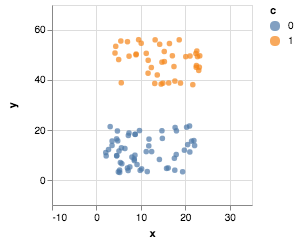

In [9]:
VegaLite({
    "mark": { "type": "point", "filled": "true" },
    "encoding": {
        "y": { 
            "type": "quantitative",
            "field": "y",
            "scale": { 
                "domain": [df['y'].min() - 10, df['y'].max() + 10]
            } 
        },
        "x": { 
            "type": "quantitative", 
            "field": "x", 
            "scale": { 
                "domain": [df['x'].min() - 10, df['x'].max() + 10]
            } 
        },
        "color": { "type": "nominal", "field": "c" }
    }
}, df)

Looks like we can apply clear classification with this dataset.

*You can optionally save the dataset if you want*

In [8]:
df.to_csv('gen-data.csv', index=False)

## Algorithm

The algorithm is pretty simple. The visual illustration of the algorithm is here [link goes here]

In [10]:
# %load knn_algo.py
import numpy as np

class KNN:
    def __init__ (self, k):
        """ Pass k as the hyperparameter"""
        self.k = k

    def train(self, X, y):
        """
            X is the example training matrix. Every row of X contains one training example. Each training example
            may have `d` features. If there are `m` such examples then X is `m x d` matrix.
            y is the label matrix corrosponding to each training example. Hence y is `m x 1` matrix.
        """

        # During training time stores the references of the input only
        self.tX = X
        self.ty = y

    def predict(self, X):
        """
            Predict y based on test data X.
        """

        num_training = X.shape[0]
        YPred = np.zeros(num_training, dtype = self.ty.dtype)

        for i in range(num_training):
            # Euclidean distance is used to find out the distance between two datapoint.
            distances = np.reshape(np.sqrt(np.sum(np.square(self.tX - X[i, :]), axis=1)), (-1, 1))
            # Along with the distance stack the labels so that we can vote easily
            distance_label = np.hstack((distances, self.ty))
            # Simple majority voting based on the minimum distance
            sorted_distance = distance_label[distance_label[:,0].argsort()]
            k_sorted_distance = sorted_distance[:self.k,:]
            (labels, occurence) = np.unique(k_sorted_distance[:, 1], return_counts=True)
            label = labels[occurence.argsort()[0]]
            YPred[i] = label

        return YPred

Now that our KNN algorithm is ready. Lets use it with our existing dataset

In [11]:
import knn_algo as knnalgo
knn = knnalgo.KNN(3) # 3 Nearest neighbour
knn.train(X, y)
knn.predict(np.array([[10, 100], [10, 10]]))

array([1., 0.])

Its classifying our data correctly.

# Real data

Base locaiton where data resides.

Download the data from http://www.cs.toronto.edu/~kriz/cifar.html

In [12]:
basedir_data = "./data/"

In [13]:
rel_path = basedir_data + "cifar-10-batches-py/"

Deserialize image files

In [15]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X = unpickle(rel_path + 'data_batch_1')
img_data = X[b'data']
img_label = X[b'labels']
img_label = np.array(img_label).reshape(-1, 1)

Now that our data and labels are loaded lets check the same

In [16]:
print(img_data)
print('shape', img_data.shape)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]
shape (10000, 3072)


There are 10k rows, hence 10k examples. Each example has 32 x 32 image which is 1024px. Each px has (r, g, b) value hence 3 x 1024 = 3072 values for one single image.
>  a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

---

Now lets check the labels

In [17]:
print(img_label)
print('shape', img_label.shape)

[[6]
 [9]
 [9]
 ...
 [1]
 [1]
 [5]]
shape (10000, 1)


Now we have the labels as 10000 x 1 matrix

Now lets load the testing data.

In [18]:
test_X = unpickle(rel_path + 'test_batch');
test_data = test_X[b'data']

Check if the test data shape is same as training data shape

In [19]:
print(test_data)
print('shape', test_data.shape)

[[158 159 165 ... 124 129 110]
 [235 231 232 ... 178 191 199]
 [158 158 139 ...   8   3   7]
 ...
 [ 20  19  15 ...  50  53  47]
 [ 25  15  23 ...  80  81  80]
 [ 73  98  99 ...  94  58  26]]
shape (10000, 3072)


Yes it's same. The number of cols in row the vectors are what we are checking.

---

Lets sample first 5 images from the data and see what the image file contains

In [20]:
sample_img_data = img_data[0:10, :]
print(sample_img_data)
print('shape', sample_img_data.shape)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 28  30  33 ... 100  99  96]
 [134 131 128 ... 136 137 138]
 [125 110 102 ...  82  84  86]]
shape (10, 3072)


Lets get the batch file so that image name can be displayed

In [21]:
batch = unpickle(rel_path + 'batches.meta');
meta = batch[b'label_names']
print(meta)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


Here is the procedure to show image

In [22]:
# %load show_img.py
from PIL import Image
import numpy as np
from IPython.display import display

def show_img(img_arr, label_arr, meta, index):
    """
        Given a numpy array of image from CIFAR-10 labels this method transform the data so that PIL can read and show
        the image.
        Check here how CIFAR encodes the image http://www.cs.toronto.edu/~kriz/cifar.html
    """
    
    one_img = img_arr[index, :]
    # Assume image size is 32 x 32. First 1024 px is r, next 1024 px is g, last 1024 px is b from the (r,g b) channel
    r = one_img[:1024].reshape(32, 32)
    g = one_img[1024:2048].reshape(32, 32)
    b = one_img[2048:]. reshape(32, 32)
    rgb = np.dstack([r, g, b])
    img = Image.fromarray(np.array(rgb), 'RGB')
    display(img)
    print(meta[label_arr[index][0]])

In [27]:
import show_img as si
for i in range(0, 10)
    si.show_img(sample_img_data, img_label, meta, i)

SyntaxError: invalid syntax (<ipython-input-27-f57acf62069b>, line 2)